# Week 3 Gemastik NLP

## Import Library

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('vader_lexicon')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import re

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, cohen_kappa_score, f1_score
from sklearn.utils import shuffle, class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Bidirectional, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Concatenate
from tensorflow.keras.optimizers import Adam

import keras
import keras.backend as K
from keras import ops
from keras import layers

# Set random seed for reproducibility
import random

seed = 2024
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Reading The Dataset

In [30]:
df = pd.read_csv('/content/train.csv')

train_df = df.copy()
test_df = pd.read_csv('/content/test.csv')

In [31]:
train_df.head(3)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Departement Name
0,823,NaN,So pretty but be careful,"I am 5'6"" and 140b, i'm usually a s and that i...",4,NaN,1.0,General Petite,Tops,Blouses,NaN
1,1094,50.0,Super flattering and comfortable,This dress is of great quality and design. the...,5,NaN,NaN,General,Dresses,NaN,NaN
2,251,67.0,Cozy and stylish,"I love this cardigan! its fit, however, really...",5,NaN,5.0,Initmates,Intimate,NaN,NaN


In [32]:
test_df.head(3)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Departement Name
0,0,847,47.0,Flattering shirt,This shirt is very flattering to all due to th...,NaN,6.0,General,Tops,Blouses,NaN
1,1,858,NaN,"Shimmer, surprisingly goes with lots","I ordered this in carbon for store pick up, an...",NaN,NaN,General Petite,Tops,Knits,NaN
2,2,1120,32.0,Super cute and cozy,"A flattering, super cozy coat. will work well...",NaN,0.0,General,Jackets,Outerwear,NaN


In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17614 entries, 0 to 17613
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Clothing ID              17614 non-null  int64  
 1   Age                      14068 non-null  float64
 2   Title                    14756 non-null  object 
 3   Review Text              16164 non-null  object 
 4   Rating                   17614 non-null  int64  
 5   Recommended IND          2659 non-null   float64
 6   Positive Feedback Count  10565 non-null  float64
 7   Division Name            14973 non-null  object 
 8   Department Name          17602 non-null  object 
 9   Class Name               13153 non-null  object 
 10  Departement Name         0 non-null      float64
dtypes: float64(4), int64(2), object(5)
memory usage: 1.5+ MB


In [34]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5872 entries, 0 to 5871
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               5872 non-null   int64  
 1   Clothing ID              5872 non-null   int64  
 2   Age                      4721 non-null   float64
 3   Title                    4920 non-null   object 
 4   Review Text              5357 non-null   object 
 5   Recommended IND          864 non-null    float64
 6   Positive Feedback Count  3527 non-null   float64
 7   Division Name            4976 non-null   object 
 8   Department Name          5870 non-null   object 
 9   Class Name               4451 non-null   object 
 10  Departement Name         0 non-null      float64
dtypes: float64(4), int64(2), object(5)
memory usage: 504.8+ KB


In [35]:
train_df.isnull().sum(), train_df.isnull().sum() / len(train_df)

(Clothing ID                    0
 Age                         3546
 Title                       2858
 Review Text                 1450
 Rating                         0
 Recommended IND            14955
 Positive Feedback Count     7049
 Division Name               2641
 Department Name               12
 Class Name                  4461
 Departement Name           17614
 dtype: int64,
 Clothing ID                0.000000
 Age                        0.201317
 Title                      0.162257
 Review Text                0.082321
 Rating                     0.000000
 Recommended IND            0.849041
 Positive Feedback Count    0.400193
 Division Name              0.149938
 Department Name            0.000681
 Class Name                 0.253264
 Departement Name           1.000000
 dtype: float64)

In [36]:
test_df.isnull().sum(), test_df.isnull().sum() / len(test_df)

(Unnamed: 0                    0
 Clothing ID                   0
 Age                        1151
 Title                       952
 Review Text                 515
 Recommended IND            5008
 Positive Feedback Count    2345
 Division Name               896
 Department Name               2
 Class Name                 1421
 Departement Name           5872
 dtype: int64,
 Unnamed: 0                 0.000000
 Clothing ID                0.000000
 Age                        0.196015
 Title                      0.162125
 Review Text                0.087704
 Recommended IND            0.852861
 Positive Feedback Count    0.399353
 Division Name              0.152589
 Department Name            0.000341
 Class Name                 0.241996
 Departement Name           1.000000
 dtype: float64)

In [37]:
train_df.duplicated().sum()
train_df.drop_duplicates(inplace=True)

In [38]:
test_df.duplicated().sum()

0

In [39]:
test_df['Title'] = test_df['Title'].fillna('')
test_df['Review Text'] = test_df['Review Text'].fillna('')

## Feature Creation & Fill Missing Value

In [40]:
# Fungsi untuk mengisi Title dan Review Text berdasarkan Rating
def fill_based_on_rating(row):
    if row['Rating'] == 0:
        if pd.isna(row['Title']) or row['Title'].strip() == '':
            row['Title'] = 'Poor Product'
        if pd.isna(row['Review Text']) or row['Review Text'].strip() == '':
            row['Review Text'] = 'This product is poor.'
    elif row['Rating'] == 1:
        if pd.isna(row['Title']) or row['Title'].strip() == '':
            row['Title'] = 'Bad Product'
        if pd.isna(row['Review Text']) or row['Review Text'].strip() == '':
            row['Review Text'] = 'This product did not meet my expectations.'
    elif row['Rating'] == 2:
        if pd.isna(row['Title']) or row['Title'].strip() == '':
            row['Title'] = 'Average Product'
        if pd.isna(row['Review Text']) or row['Review Text'].strip() == '':
            row['Review Text'] = 'This product is okay, but could be better.'
    elif row['Rating'] == 3:
        if pd.isna(row['Title']) or row['Title'].strip() == '':
            row['Title'] = 'Good Product'
        if pd.isna(row['Review Text']) or row['Review Text'].strip() == '':
            row['Review Text'] = 'This product is good and meets expectations.'
    elif row['Rating'] == 4:
        if pd.isna(row['Title']) or row['Title'].strip() == '':
            row['Title'] = 'Very Good Product'
        if pd.isna(row['Review Text']) or row['Review Text'].strip() == '':
            row['Review Text'] = 'This product is very good and exceeded expectations.'
    elif row['Rating'] == 5:
        if pd.isna(row['Title']) or row['Title'].strip() == '':
            row['Title'] = 'Excellent Product'
        if pd.isna(row['Review Text']) or row['Review Text'].strip() == '':
            row['Review Text'] = 'This product is excellent and highly recommended.'

    return row

# Terapkan fungsi pada DataFrame
train_df = train_df.apply(fill_based_on_rating, axis=1)

In [41]:
# Menggabungkan kolom
train_df['Text'] = train_df['Title'] + '. ' + train_df['Review Text']
test_df['Text'] = test_df['Title'] + '. ' + test_df['Review Text']

## Data Cleaning

### Selecting Relevant Column

In [42]:
train_df = train_df[["Title","Review Text","Text", "Department Name", "Class Name", "Division Name", "Rating"]]
test_df = test_df[["Title","Review Text","Text", "Department Name", "Class Name", "Division Name"]]

In [43]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17608 entries, 0 to 17613
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Title            17608 non-null  object
 1   Review Text      17608 non-null  object
 2   Text             17608 non-null  object
 3   Department Name  17596 non-null  object
 4   Class Name       13148 non-null  object
 5   Division Name    14967 non-null  object
 6   Rating           17608 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 1.1+ MB


In [44]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5872 entries, 0 to 5871
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Title            5872 non-null   object
 1   Review Text      5872 non-null   object
 2   Text             5872 non-null   object
 3   Department Name  5870 non-null   object
 4   Class Name       4451 non-null   object
 5   Division Name    4976 non-null   object
dtypes: object(6)
memory usage: 275.4+ KB


### Drop Missing Value

In [45]:
train_df.dropna(inplace=True)
# test_df.dropna(inplace=True)

In [46]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

# Fungsi untuk mendapatkan skor sentimen
def get_sentiment_scores(text):
    scores = analyzer.polarity_scores(text)
    return scores['neg'], scores['neu'], scores['pos'], scores['compound']

# Buat fitur baru untuk Title
train_df['Title_Negative'], train_df['Title_Neutral'], train_df['Title_Positive'], train_df['Title_Compound'] = zip(*train_df['Title'].apply(get_sentiment_scores))
test_df['Title_Negative'], test_df['Title_Neutral'], test_df['Title_Positive'], test_df['Title_Compound'] = zip(*test_df['Title'].apply(get_sentiment_scores))

# Buat fitur baru untuk Review Text
train_df['Review_Negative'], train_df['Review_Neutral'], train_df['Review_Positive'], train_df['Review_Compound'] = zip(*train_df['Review Text'].apply(get_sentiment_scores))
test_df['Review_Negative'], test_df['Review_Neutral'], test_df['Review_Positive'], test_df['Review_Compound'] = zip(*test_df['Review Text'].apply(get_sentiment_scores))

In [47]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11183 entries, 0 to 17610
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            11183 non-null  object 
 1   Review Text      11183 non-null  object 
 2   Text             11183 non-null  object 
 3   Department Name  11183 non-null  object 
 4   Class Name       11183 non-null  object 
 5   Division Name    11183 non-null  object 
 6   Rating           11183 non-null  int64  
 7   Title_Negative   11183 non-null  float64
 8   Title_Neutral    11183 non-null  float64
 9   Title_Positive   11183 non-null  float64
 10  Title_Compound   11183 non-null  float64
 11  Review_Negative  11183 non-null  float64
 12  Review_Neutral   11183 non-null  float64
 13  Review_Positive  11183 non-null  float64
 14  Review_Compound  11183 non-null  float64
dtypes: float64(8), int64(1), object(6)
memory usage: 1.4+ MB


In [48]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5872 entries, 0 to 5871
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            5872 non-null   object 
 1   Review Text      5872 non-null   object 
 2   Text             5872 non-null   object 
 3   Department Name  5870 non-null   object 
 4   Class Name       4451 non-null   object 
 5   Division Name    4976 non-null   object 
 6   Title_Negative   5872 non-null   float64
 7   Title_Neutral    5872 non-null   float64
 8   Title_Positive   5872 non-null   float64
 9   Title_Compound   5872 non-null   float64
 10  Review_Negative  5872 non-null   float64
 11  Review_Neutral   5872 non-null   float64
 12  Review_Positive  5872 non-null   float64
 13  Review_Compound  5872 non-null   float64
dtypes: float64(8), object(6)
memory usage: 642.4+ KB


In [49]:
train_df = train_df.drop(columns = ["Title", "Review Text","Department Name", "Class Name", "Division Name"])
test_df = test_df.drop(columns = ["Title", "Review Text","Department Name", "Class Name", "Division Name"])

### Text Cleaning

#### Defining Negation Word

In [50]:
all_stopwords = stopwords.words('english')

# Kata-kata negasi yang ingin dihapus dari kumpulan stopwords
kata_negasi = ['not', 'no', 'never', 'none']

# Hapus kata-kata negasi dari kumpulan stopwords
stopwords = [word for word in all_stopwords if word not in kata_negasi]

In [51]:
train_df.isnull().sum()

,0
Text,0
Rating,0
Title_Negative,0
Title_Neutral,0
Title_Positive,0
Title_Compound,0
Review_Negative,0
Review_Neutral,0
Review_Positive,0
Review_Compound,0


In [52]:
def preprocess_text(text):
    # Konversi teks ke huruf kecil
    text = text.lower()
    # Menghapus whitespace ekstra
    text = ' '.join(text.split())
    # # Menghapus stopwords yang sudah ditentukan
    # words = [word for word in text.split() if word not in stopwords]
    # Gabungkan kata-kata kembali menjadi satu string
    processed_text = ' '.join(text.split())

    return processed_text

train_df["Text"] = train_df["Text"].apply(preprocess_text)
test_df["Text"] = test_df["Text"].apply(preprocess_text)

In [53]:
contraction_mapping = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he had",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how does",
    "I'd": "I had",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she had",
    "she'd've": "she would have",
    "she'll": "she she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that had",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they had",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
}

def expand_contractions(text, contraction_mapping):
    for contraction, expanded in contraction_mapping.items():
        text = text.replace(contraction, expanded)
    return text

train_df['Text'] = train_df['Text'].apply(lambda x: expand_contractions(x, contraction_mapping))
test_df['Text'] = test_df['Text'].apply(lambda x: expand_contractions(x, contraction_mapping))

In [54]:
train_df.head(3)

,Text,Rating,Title_Negative,Title_Neutral,Title_Positive,Title_Compound,Review_Negative,Review_Neutral,Review_Positive,Review_Compound
0,"so pretty but be careful. i am 5'6"" and 140b, ...",4,0.0,0.420,0.580,0.4848,0.000,0.841,0.159,0.8885
3,very good product. the fabric is lovely and th...,4,0.0,0.385,0.615,0.4927,0.075,0.573,0.351,0.8271
4,great buy!. this product is excellent and high...,5,0.0,0.185,0.815,0.6588,0.000,0.463,0.537,0.6997


In [55]:
test_df.head(3)

,Text,Title_Negative,Title_Neutral,Title_Positive,Title_Compound,Review_Negative,Review_Neutral,Review_Positive,Review_Compound
0,flattering shirt. this shirt is very flatterin...,0.0,0.303,0.697,0.3182,0.000,0.700,0.300,0.9291
1,"shimmer, surprisingly goes with lots. i ordere...",0.0,0.645,0.355,0.2960,0.046,0.901,0.053,-0.0909
2,"super cute and cozy. a flattering, super cozy ...",0.0,0.225,0.775,0.7845,0.000,0.620,0.380,0.9360


## EDA



### Defining Analysis Question

1.   Bagaimana Perbandingan Rating ?
2.   Bagaimana Perbandingan Panjang Teks Antar Rating ?
3.   Ada Berapa Jumlah Departement ?
4.   Bagaimana Perbandingan Rating Antar Departement
5.   Ada Berapa Jumlah Kelas ?
6.   Bagaimana Perbandingan Rating Antar Kelas ?
7.   Ada Berapa Jumlah Divisi ?
8.   Bagaimana Perbandingan Jumlah Divisi Antar Kelas ?
9.   Kata Apa Yang Paling Banyak Diucapkan Antar Rating ?

#### Visualisasi Perbandingan Rating

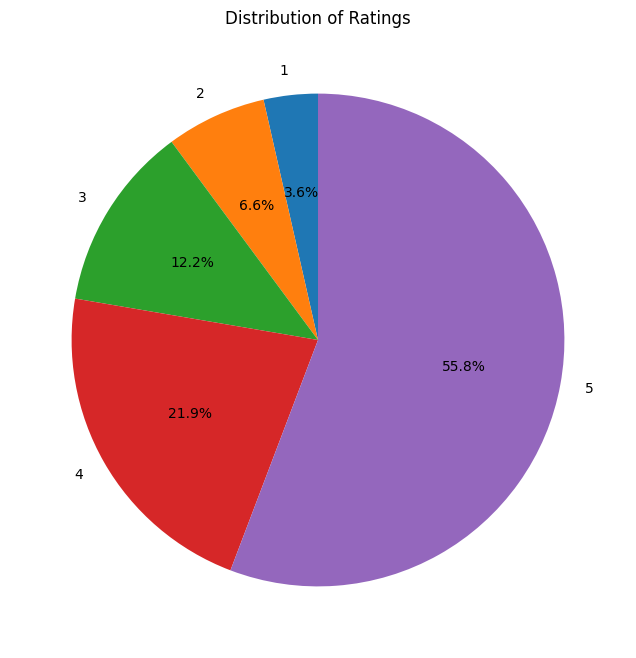

In [56]:
rating_counts = train_df["Rating"].value_counts().sort_values()

plt.figure(figsize=(8, 8))
plt.pie(rating_counts, labels=rating_counts.index, autopct="%1.1f%%", startangle=90)
plt.title("Distribution of Ratings")
plt.show()

#### Visualisasi Perbandingan Panjang Teks Antar Rating

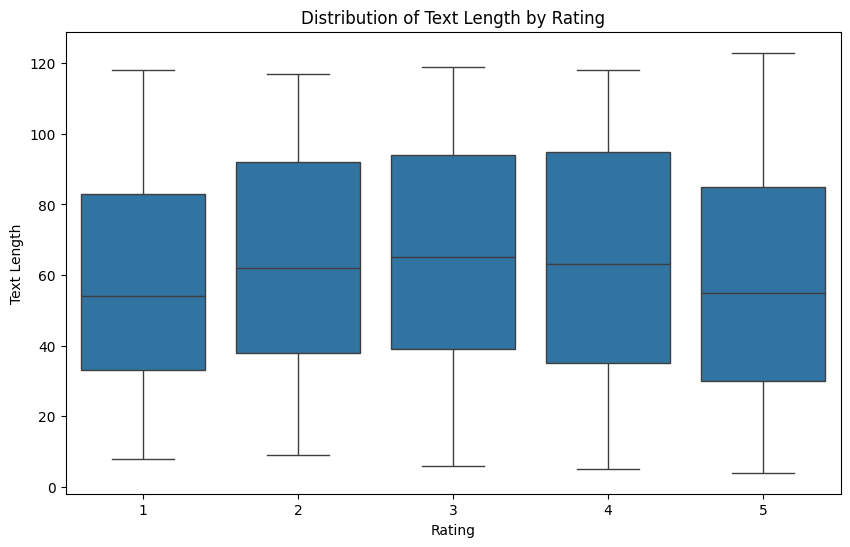

In [57]:
train_df['Text Length'] = train_df['Text'].apply(lambda x: len(x.split()))
test_df['Text Length'] = test_df['Text'].apply(lambda x: len(x.split()))

## generate text length visualization using boxplot between rating
plt.figure(figsize=(10, 6))
sns.boxplot(x='Rating', y='Text Length', data=train_df)
plt.title('Distribution of Text Length by Rating')
plt.show()

#### Visualisasi Jumlah Departement

In [58]:
# department_counts = train_df["Department Name"].value_counts().sort_values(ascending = False)
# department_counts

# plt.figure(figsize=(10, 6))
# sns.barplot(x=department_counts.index, y=department_counts.values)
# plt.title('Distribution of Departments')
# plt.show()

#### Kata Apa Yang Paling Banyak Diucapkan Antar Rating ?

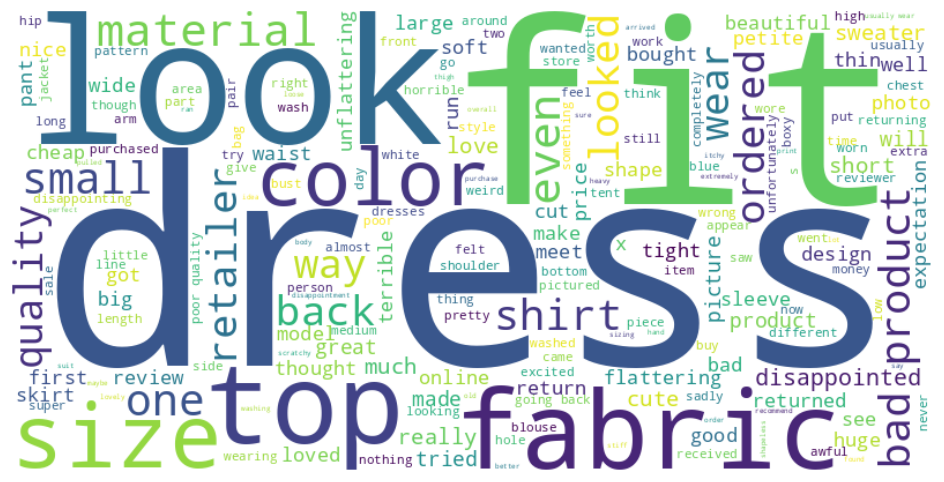

In [59]:
from wordcloud import WordCloud

text = " ".join(train_df[train_df["Rating"] == 1]["Text"])

# Membuat WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

# Menampilkan WordCloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

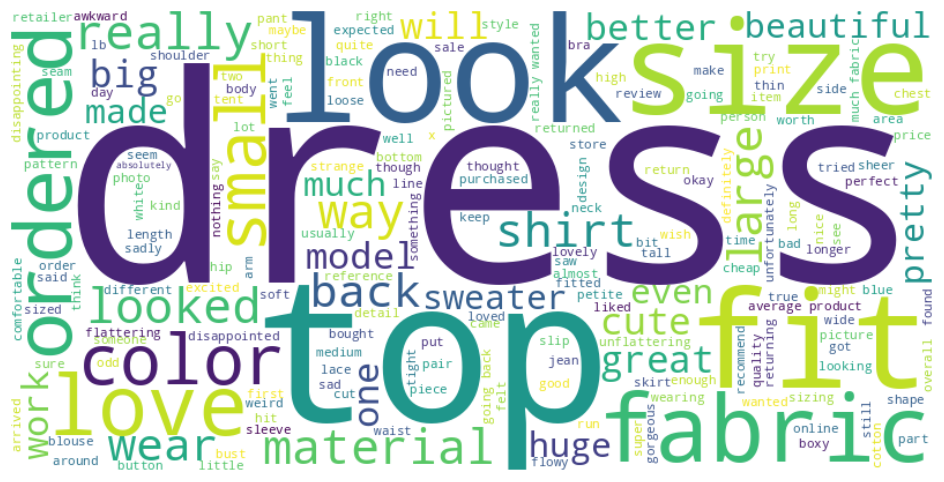

In [60]:
from wordcloud import WordCloud

text = " ".join(train_df[train_df["Rating"] == 2]["Text"])

# Membuat WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

# Menampilkan WordCloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

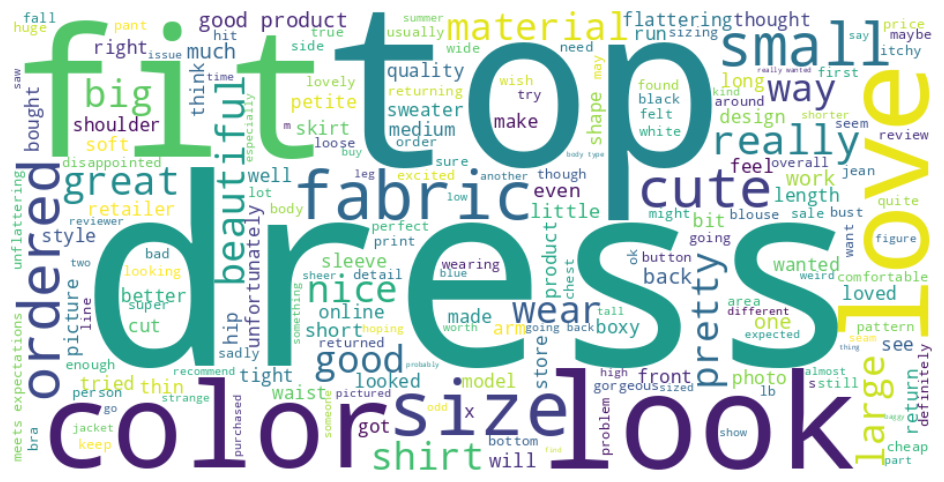

In [61]:
from wordcloud import WordCloud

text = " ".join(train_df[train_df["Rating"] == 3]["Text"])

# Membuat WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

# Menampilkan WordCloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

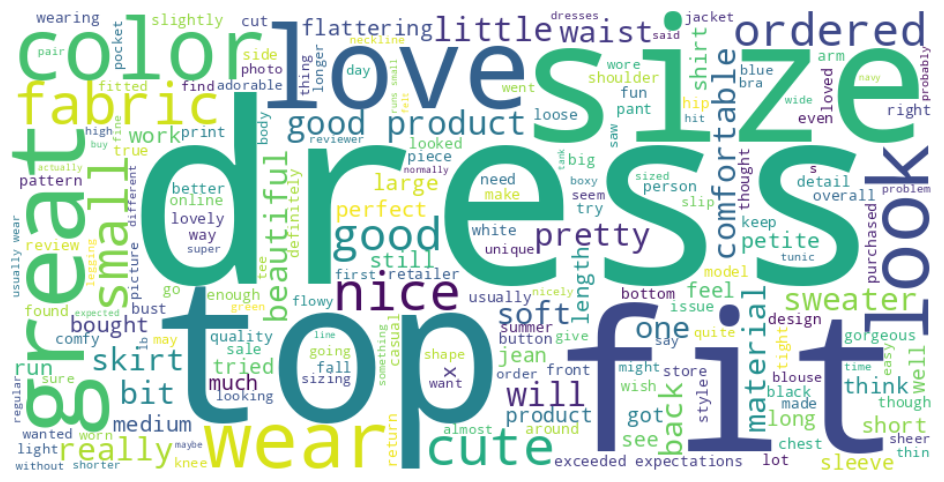

In [62]:
from wordcloud import WordCloud

text = " ".join(train_df[train_df["Rating"] == 4]["Text"])

# Membuat WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

# Menampilkan WordCloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

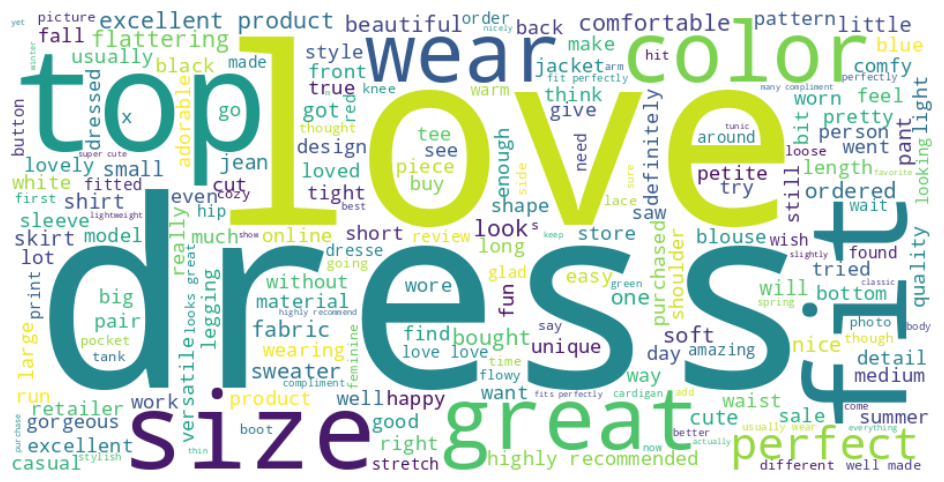

In [63]:
from wordcloud import WordCloud

text = " ".join(train_df[train_df["Rating"] == 5]["Text"])

# Membuat WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

# Menampilkan WordCloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Kata Penting Apa Yang Diucapkan Antar Rating ?

In [64]:
def find_influential_words_tfidf(df, rating, top_n=20):
    # Pra-pemrosesan teks
    df_filtered = df[df['Rating'] == rating]
    df_filtered['Text'] = df_filtered['Text'].apply(preprocess_text)

    # TF-IDF Vectorization
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(df_filtered['Text'])

    # Ambil nama fitur (kata-kata)
    feature_names = vectorizer.get_feature_names_out()

    # Hitung nilai rata-rata TF-IDF untuk setiap fitur (kata)
    tfidf_means = X.mean(axis=0).tolist()[0]

    # Gabungkan nama fitur dan nilai TF-IDF
    word_tfidf = dict(zip(feature_names, tfidf_means))

    # Ambil kata-kata dengan nilai TF-IDF tertinggi (misalnya top 20)
    influential_words = sorted(word_tfidf.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return influential_words

In [65]:
rating = 1
influential_words_tfidf = find_influential_words_tfidf(train_df, rating, top_n=50)
print(f"Kata berpengaruh untuk rating '{rating}':")
for word, tfidf_score in influential_words_tfidf:
    print(f"{word}: {tfidf_score}")

Kata berpengaruh untuk rating '1':
the: 0.130840548759879
it: 0.08669403489461382
and: 0.07061992543873394
is: 0.0667355423389691
not: 0.05942315165005689
this: 0.05841563807399687
product: 0.05064674243493016
was: 0.0494633084610333
to: 0.047300151459417135
in: 0.04482803314398992
my: 0.04217991546207814
of: 0.038424074953234716
on: 0.03829069043699015
but: 0.03803353940933298
did: 0.03783816689578061
dress: 0.03694560476728681
so: 0.03537402651436527
expectations: 0.03332389308450647
meet: 0.03330430464164662
bad: 0.03168846185101585
like: 0.030703337960673278
for: 0.028792359865596348
as: 0.028779723153643605
very: 0.02800183395673262
top: 0.026986744921106275
fit: 0.025868540626764597
fabric: 0.02526068324349978
that: 0.02513290657788347
too: 0.024750134113527184
have: 0.02330981017051838
at: 0.02315173502137326
are: 0.022774147171920917
me: 0.021122549359514114
be: 0.02086791743968934
size: 0.020633825503574302
material: 0.02044965836978798
they: 0.019737408165785973
you: 0.019532

<ipython-input-64-6991db430722>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Text'] = df_filtered['Text'].apply(preprocess_text)


In [66]:
rating = 2
influential_words_tfidf = find_influential_words_tfidf(train_df, rating, top_n=50)
print(f"Kata berpengaruh untuk rating '{rating}':")
for word, tfidf_score in influential_words_tfidf:
    print(f"{word}: {tfidf_score}")

Kata berpengaruh untuk rating '2':
the: 0.12931061765950155
it: 0.0938221370965305
and: 0.07397229264712697
is: 0.06858229406453212
this: 0.05572804749845021
was: 0.05486814782333055
not: 0.05428665759700026
to: 0.0534489446773298
but: 0.052823922193168435
in: 0.04475429364591637
on: 0.04136607130127365
product: 0.0392351307138623
be: 0.03727359231836683
dress: 0.03585832010278473
of: 0.035096087495017594
for: 0.03490700958627402
too: 0.03425293320177327
so: 0.03244249703533741
could: 0.03241742093398801
like: 0.03123130421205137
top: 0.03015811276791928
very: 0.029883273338901704
better: 0.029822005967743696
okay: 0.029194201761345583
me: 0.02902412140027082
my: 0.02755159745114024
have: 0.026702638569490598
that: 0.026556590469850302
would: 0.0261244732045184
fabric: 0.02593473394802361
with: 0.02473736457201393
size: 0.02442257711338727
just: 0.02425822540363463
fit: 0.024181007461489813
small: 0.02370625979326468
as: 0.023527733749464444
did: 0.02231075745359342
love: 0.02078971427

<ipython-input-64-6991db430722>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Text'] = df_filtered['Text'].apply(preprocess_text)


In [67]:
rating = 3
influential_words_tfidf = find_influential_words_tfidf(train_df, rating, top_n=50)
print(f"Kata berpengaruh untuk rating '{rating}':")
for word, tfidf_score in influential_words_tfidf:
    print(f"{word}: {tfidf_score}")

<ipython-input-64-6991db430722>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Text'] = df_filtered['Text'].apply(preprocess_text)


Kata berpengaruh untuk rating '3':
the: 0.1289932248856214
it: 0.09003689569380663
and: 0.0771525948711881
is: 0.07035870447426588
this: 0.052920120667102395
not: 0.05150707857918603
to: 0.050949090720134205
but: 0.05009020213933146
was: 0.04962344080652252
in: 0.0455850662746967
good: 0.0419682771138986
on: 0.04153004047018808
product: 0.03981296647991983
for: 0.039739951000713196
dress: 0.03724701636512444
of: 0.03584791991915376
too: 0.03239864021106813
top: 0.031213987599010243
me: 0.030983820926889203
very: 0.030851894857437764
so: 0.030537496781307634
my: 0.029593788508142052
like: 0.02742911897561312
have: 0.027107628523733867
fit: 0.027074725715066125
that: 0.026647521649459664
meets: 0.02598933758712685
expectations: 0.02597436387512649
with: 0.02487359789900487
would: 0.02473951714820972
just: 0.024607260848383678
size: 0.023917353504190896
love: 0.023855816318322957
cute: 0.023181715079225482
small: 0.023088065841018524
as: 0.022727264401134317
are: 0.022520316272808504
fabr

In [68]:
rating = 4
influential_words_tfidf = find_influential_words_tfidf(train_df, rating, top_n=50)
print(f"Kata berpengaruh untuk rating '{rating}':")
for word, tfidf_score in influential_words_tfidf:
    print(f"{word}: {tfidf_score}")

<ipython-input-64-6991db430722>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Text'] = df_filtered['Text'].apply(preprocess_text)


Kata berpengaruh untuk rating '4':
the: 0.11945768471475084
it: 0.0871833135061354
and: 0.08081842736860792
is: 0.07577262736280067
very: 0.056145753719343994
this: 0.052933036463195866
good: 0.04904032645925412
to: 0.048241599246141666
product: 0.047695958797030445
but: 0.044190694001257635
in: 0.04323485992550952
not: 0.040694794941135516
dress: 0.038014063878486985
for: 0.036700448736994885
on: 0.03600611352010335
was: 0.031993273777453056
of: 0.03142390885321193
top: 0.03139628824387475
expectations: 0.030683930299347625
exceeded: 0.030682022391582263
with: 0.03057380611220686
that: 0.02950352885006595
size: 0.02922263657200066
so: 0.029202095465096334
my: 0.028036788807910412
great: 0.027330237254444785
love: 0.025832849649085884
cute: 0.025814536451112848
have: 0.024657800174173548
are: 0.024215727150981328
fit: 0.023372569251734625
like: 0.023050866009890973
me: 0.02296486929012616
be: 0.022481880887294022
as: 0.021901700909341893
small: 0.021809197988577736
too: 0.0215042607735

In [69]:
rating = 5
influential_words_tfidf = find_influential_words_tfidf(train_df, rating, top_n=50)
print(f"Kata berpengaruh untuk rating '{rating}':")
for word, tfidf_score in influential_words_tfidf:
    print(f"{word}: {tfidf_score}")

<ipython-input-64-6991db430722>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Text'] = df_filtered['Text'].apply(preprocess_text)


Kata berpengaruh untuk rating '5':
the: 0.1029057799191975
and: 0.0873537555874951
it: 0.08335557735416375
is: 0.07426503578696236
this: 0.05870185483759786
product: 0.054214668137426605
excellent: 0.05413919824021238
to: 0.046780881515847375
in: 0.042750625973395275
dress: 0.03985540792810483
love: 0.03936852264593684
with: 0.03534255712401324
for: 0.035157307646149806
highly: 0.03459743307616761
so: 0.034300556205341816
recommended: 0.03404958346996027
great: 0.03340578423615696
on: 0.03238964406819433
not: 0.03219314444681397
but: 0.03181267799256705
of: 0.029809670928905605
top: 0.028885523088902815
my: 0.028278374539279293
very: 0.02752195153853099
size: 0.026440830437191164
are: 0.024966747159493218
fit: 0.024752874906870993
was: 0.024353655987764025
perfect: 0.02431636020712576
that: 0.02365042176595145
wear: 0.022947363416405665
or: 0.022165459407060804
have: 0.021588142108875656
as: 0.02115389446819865
they: 0.02066749997138357
be: 0.02063097105280144
beautiful: 0.020572224200

## Generate Lexicon Score

In [70]:
# # Contoh penggunaan untuk semua label dan penyimpanan ke dalam struktur topic_keywords
# topic_keywords = {}

# # Definisikan label dan ekstraksi kata-kata berpengaruh menggunakan TF-IDF
# labels = train_df['Rating'].unique()
# for label in labels:
#     influential_words_tfidf = find_influential_words_tfidf(train_df, label, top_n=50)
#     topic_keywords[label] = [word for word, _ in influential_words_tfidf]

In [71]:
# # Fungsi untuk menghitung skor untuk setiap topik
# def topic_scores(text, topic_keywords):
#     words = text.split()
#     total_words = len(words)
#     scores = {}
#     for topic, keywords in topic_keywords.items():
#         keyword_count = sum(1 for word in words if word in keywords)
#         score = keyword_count / total_words if total_words > 0 else 0
#         scores[f'{topic}_score'] = score
#     return scores

In [72]:
# # Tambahkan fitur skor untuk setiap topik
# topic_scores_train_df = train_df['Text'].apply(lambda text: pd.Series(topic_scores(text, topic_keywords)))
# topic_scores_test_df = test_df['Text'].apply(lambda text: pd.Series(topic_scores(text, topic_keywords)))

# train_df = pd.concat([train_df, topic_scores_train_df], axis=1)
# test_df = pd.concat([test_df, topic_scores_test_df], axis=1)

In [73]:
# train_df.head()

In [74]:
# train_df = train_df.drop(columns = ["Department Name", "Class Name", "Division Name"])
# test_df = test_df.drop(columns = ["Department Name", "Class Name", "Division Name"])

## Splitting Dependent and Independent Variable

In [75]:
X = train_df.drop(['Rating'], axis=1)
y = train_df['Rating']

In [76]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11183 entries, 0 to 17610
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Text             11183 non-null  object 
 1   Title_Negative   11183 non-null  float64
 2   Title_Neutral    11183 non-null  float64
 3   Title_Positive   11183 non-null  float64
 4   Title_Compound   11183 non-null  float64
 5   Review_Negative  11183 non-null  float64
 6   Review_Neutral   11183 non-null  float64
 7   Review_Positive  11183 non-null  float64
 8   Review_Compound  11183 non-null  float64
 9   Text Length      11183 non-null  int64  
dtypes: float64(8), int64(1), object(1)
memory usage: 961.0+ KB


In [77]:
y.info()

<class 'pandas.core.series.Series'>
Index: 11183 entries, 0 to 17610
Series name: Rating
Non-Null Count  Dtype
--------------  -----
11183 non-null  int64
dtypes: int64(1)
memory usage: 174.7 KB


## Splitting Data Into Train and Test

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

In [79]:
## Subtracting y value with one and change it into the array
## for keras and class_weight compatibility

y_train = y_train - 1
y_test = y_test - 1

y_train = y_train.astype(int)
y_test = y_test.astype(int)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [80]:
X_train.shape, y_train.shape

((8387, 10), (8387,))

In [95]:
X_test.shape, y_test.shape

((2796, 10), (2796,))

## Setting Hyperparameter

In [81]:
max_len = train_df['Text Length'].max()
vocab_size = 1000
embedding_dim = 32
drop_value = 0.2
early_stop = EarlyStopping(monitor='val_loss', patience=15)

## Text Vectorization

In [96]:
tokenizer = Tokenizer(num_words=vocab_size, char_level=False, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train['Text'])  # Tokenisasi berdasarkan teks di data pelatihan

# Tokenisasi dan padding untuk data pelatihan
training_sequences = tokenizer.texts_to_sequences(X_train['Text'])
training_padded = pad_sequences(training_sequences, maxlen=max_len, padding='pre', truncating='post')

# Tokenisasi dan padding untuk data uji
testing_sequences = tokenizer.texts_to_sequences(X_test['Text'])  # Hanya teks dari X_test yang digunakan
testing_padded = pad_sequences(testing_sequences, maxlen=max_len, padding='pre', truncating='post')

In [97]:
# Siapkan data numerik
X_train_numerical = X_train[['Title_Negative', 'Title_Neutral', 'Title_Positive', 'Title_Compound',
                             'Review_Negative', 'Review_Neutral', 'Review_Positive', 'Review_Compound']].values
X_test_numerical = X_test[['Title_Negative', 'Title_Neutral', 'Title_Positive', 'Title_Compound',
                           'Review_Negative', 'Review_Neutral', 'Review_Positive', 'Review_Compound']].values

# Verifikasi ukuran data input
print("Shape of training_padded:", training_padded.shape)
print("Shape of X_train_numerical:", X_train_numerical.shape)
print("Shape of y_train:", y_train.shape)

# Pastikan ukuran dari semua data input sama
assert training_padded.shape[0] == X_train_numerical.shape[0] == y_train.shape[0], "Ukuran X dan y tidak sesuai!"

Shape of training_padded: (8387, 123)
Shape of X_train_numerical: (8387, 8)
Shape of y_train: (8387,)


In [98]:
print("training_padded shape:", training_padded.shape)
print("X_train_numerical shape:", X_train_numerical.shape)
print("y_train shape:", y_train.shape)

print()

print("testing_padded shape:", testing_padded.shape)
print("X_test_numerical shape:", X_test_numerical.shape)
print("y_test shape:", y_test.shape)

training_padded shape: (8387, 123)
X_train_numerical shape: (8387, 8)
y_train shape: (8387,)

testing_padded shape: (2796, 123)
X_test_numerical shape: (2796, 8)
y_test shape: (2796,)


## Defining Class Weight

In [99]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 5.686101694915254,
 1: 3.027797833935018,
 2: 1.619111969111969,
 3: 0.9226622662266226,
 4: 0.3581127241673783}

## Defining Model Architecture

### LSTM

In [100]:
# Model LSTM dengan penggabungan fitur numerik
input_text = Input(shape=(max_len,))
embedding = Embedding(vocab_size, embedding_dim, input_length=max_len)(input_text)
spatial_dropout = SpatialDropout1D(drop_value)(embedding)
lstm = LSTM(64, return_sequences=False)(spatial_dropout)
dropout = Dropout(drop_value)(lstm)

# Fitur numerik
input_numerical = Input(shape=(8,))  # 8 adalah jumlah fitur numerik

# Gabungkan output LSTM dan fitur numerik
combined = Concatenate()([dropout, input_numerical])

# Lapisan Dense dan output
dense = Dense(64, activation='relu')(combined)
output = Dense(5, activation='softmax')(dense)

# Model
model1 = Model(inputs=[input_text, input_numerical], outputs=output)
model1.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.AdamW(), metrics=["accuracy"])
model1.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 123)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 123, 32)        │         32,000 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout1d_1       │ (None, 123, 32)        │              0 │ embedding_1[0][0]      │
│ (SpatialDropout1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 64)             │         24,832 │ spatial_dropout1d_1[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 8)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 72)             │              0 │ dropout_1[0][0],       │
│ (Concatenate)             │                        │                │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │          4,672 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 5)              │            325 │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 61,829 (241.52 KB)

 Trainable params: 61,829 (241.52 KB)

 Non-trainable params: 0 (0.00 B)

#### Train the Model

In [101]:
history1 = model1.fit([training_padded, X_train_numerical], y_train, epochs=30,
                    validation_data=([testing_padded, X_test_numerical], y_test),
                    class_weight=class_weight_dict, verbose=1, callbacks=[early_stop])

Epoch 1/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.4707 - loss: 1.4707 - val_accuracy: 0.5604 - val_loss: 1.0040
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5775 - loss: 1.1478 - val_accuracy: 0.5633 - val_loss: 1.0033
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6293 - loss: 1.0403 - val_accuracy: 0.5676 - val_loss: 0.9590
Epoch 4/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6459 - loss: 0.9509 - val_accuracy: 0.5379 - val_loss: 0.9747
Epoch 5/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6648 - loss: 0.8705 - val_accuracy: 0.5948 - val_loss: 0.9183
Epoch 6/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6689 - loss: 0.8320 - val_accuracy: 0.5951 - val_loss: 0.9493
Epoch 7/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6992 - loss: 0.7609 - val_accuracy: 0.5776 - val_loss: 1.0529
Epoch 8/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7037 - loss: 0.7127 - val_accuracy:

#### Trained Model Loss Visualization

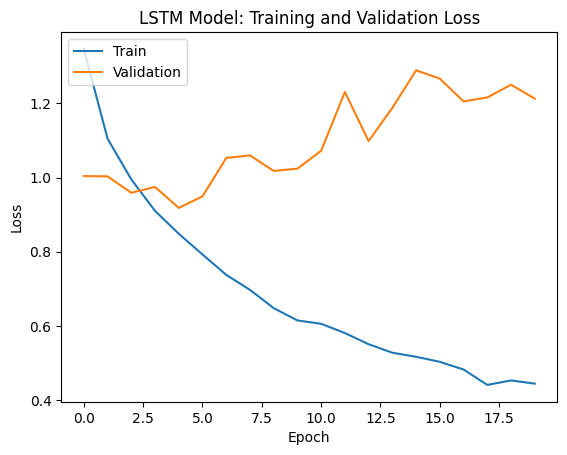

In [102]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('LSTM Model: Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Model Performances

In [103]:
# Gabungkan data numerik dengan data teks untuk prediksi
y_pred_prob = model1.predict([testing_padded, X_test_numerical])
y_pred_classes = np.argmax(y_pred_prob, axis=1)  # Get the predicted class

# Menampilkan classification report
print(classification_report(y_test, y_pred_classes))

# Menghitung metrik lainnya
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')  # Use weighted for multiclass
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

# Menghitung Quadratic Weighted Kappa
qwk = cohen_kappa_score(y_test, y_pred_classes, weights='quadratic')

# Menampilkan metrik secara terpisah
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'Quadratic Weighted Kappa: {qwk:.2f}')

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

           0       0.32      0.49      0.39       102
           1       0.27      0.27      0.27       182
           2       0.40      0.40      0.40       326
           3       0.40      0.54      0.46       632
           4       0.86      0.71      0.77      1554

    accuracy                           0.60      2796
   macro avg       0.45      0.48      0.46      2796
weighted avg       0.64      0.60      0.61      2796

Accuracy: 0.60
Precision: 0.64
Recall: 0.60
F1 Score: 0.61
Quadratic Weighted Kappa: 0.69


### GRU

In [104]:
# Model GRU dengan penggabungan fitur numerik
input_text = Input(shape=(max_len,))
embedding = Embedding(vocab_size, embedding_dim, input_length=max_len)(input_text)
spatial_dropout = SpatialDropout1D(drop_value)(embedding)
gru = GRU(64, return_sequences=False)(spatial_dropout)
dropout = Dropout(drop_value)(gru)

# Fitur numerik
input_numerical = Input(shape=(8,))  # 8 adalah jumlah fitur numerik

# Gabungkan output GRU dan fitur numerik
combined = Concatenate()([dropout, input_numerical])

# Lapisan Dense dan output
dense = Dense(64, activation='relu')(combined)
output = Dense(5, activation='softmax')(dense)

# Model
model2 = Model(inputs=[input_text, input_numerical], outputs=output)
model2.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.AdamW(), metrics=["accuracy"])
model2.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 123)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 123, 32)        │         32,000 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout1d_2       │ (None, 123, 32)        │              0 │ embedding_2[0][0]      │
│ (SpatialDropout1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru (GRU)                 │ (None, 64)             │         18,816 │ spatial_dropout1d_2[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64)             │              0 │ gru[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, 8)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 72)             │              0 │ dropout_2[0][0],       │
│ (Concatenate)             │                        │                │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 64)             │          4,672 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 5)              │            325 │ dense_4[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 55,813 (218.02 KB)

 Trainable params: 55,813 (218.02 KB)

 Non-trainable params: 0 (0.00 B)

#### Train the Model

In [105]:
history2 = model2.fit([training_padded, X_train_numerical], y_train, epochs=30,
                    validation_data=([testing_padded, X_test_numerical], y_test),
                    class_weight=class_weight_dict, verbose=1, callbacks=[early_stop])


Epoch 1/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4368 - loss: 1.4860 - val_accuracy: 0.5204 - val_loss: 1.0987
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5849 - loss: 1.1533 - val_accuracy: 0.5426 - val_loss: 1.0529
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6129 - loss: 1.0521 - val_accuracy: 0.5154 - val_loss: 1.0848
Epoch 4/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6239 - loss: 0.9734 - val_accuracy: 0.5837 - val_loss: 0.9662
Epoch 5/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6629 - loss: 0.9034 - val_accuracy: 0.5891 - val_loss: 0.9522
Epoch 6/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6776 - loss: 0.8194 - val_accuracy: 0.5672 - val_loss: 0.9975
Epoch 7/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6806 - loss: 0.7764 - val_accuracy: 0.6237 - val_loss: 0.9690
Epoch 8/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6947 - loss: 0.7228 - val_accurac

#### Trained Model Loss Visualization

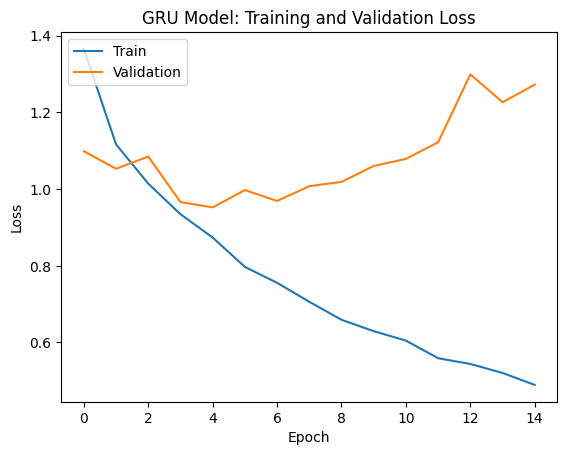

In [106]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('GRU Model: Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Model Performances

In [107]:
# Gabungkan data numerik dengan data teks untuk prediksi
y_pred_prob = model2.predict([testing_padded, X_test_numerical])
y_pred_classes = np.argmax(y_pred_prob, axis=1)  # Get the predicted class

# Menampilkan classification report
print(classification_report(y_test, y_pred_classes))

# Menghitung metrik lainnya
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')  # Use weighted for multiclass
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

# Menghitung Quadratic Weighted Kappa
qwk = cohen_kappa_score(y_test, y_pred_classes, weights='quadratic')

# Menampilkan metrik secara terpisah
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'Quadratic Weighted Kappa: {qwk:.2f}')

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
              precision    recall  f1-score   support

           0       0.31      0.51      0.38       102
           1       0.23      0.30      0.26       182
           2       0.34      0.43      0.38       326
           3       0.38      0.57      0.46       632
           4       0.92      0.60      0.73      1554

    accuracy                           0.55      2796
   macro avg       0.43      0.48      0.44      2796
weighted avg       0.66      0.55      0.58      2796

Accuracy: 0.55
Precision: 0.66
Recall: 0.55
F1 Score: 0.58
Quadratic Weighted Kappa: 0.68


### Bi-LSTM

In [108]:
# Model Bi-LSTM dengan penggabungan fitur numerik
input_text = Input(shape=(max_len,))
embedding = Embedding(vocab_size, embedding_dim, input_length=max_len)(input_text)
spatial_dropout = SpatialDropout1D(drop_value)(embedding)
bi_lstm = Bidirectional(LSTM(64, return_sequences=False))(spatial_dropout)
dropout = Dropout(drop_value)(bi_lstm)

# Fitur numerik
input_numerical = Input(shape=(8,))  # 8 adalah jumlah fitur numerik

# Gabungkan output Bi-LSTM dan fitur numerik
combined = Concatenate()([dropout, input_numerical])

# Lapisan Dense dan output
dense = Dense(64, activation='relu')(combined)
output = Dense(5, activation='softmax')(dense)

# Model
model3 = Model(inputs=[input_text, input_numerical], outputs=output)
model3.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.AdamW(), metrics=["accuracy"])
model3.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 123)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 123, 32)        │         32,000 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout1d_3       │ (None, 123, 32)        │              0 │ embedding_3[0][0]      │
│ (SpatialDropout1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 128)            │         49,664 │ spatial_dropout1d_3[0… │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128)            │              0 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_7             │ (None, 8)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 136)            │              0 │ dropout_3[0][0],       │
│ (Concatenate)             │                        │                │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 64)             │          8,768 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 5)              │            325 │ dense_6[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 90,757 (354.52 KB)

 Trainable params: 90,757 (354.52 KB)

 Non-trainable params: 0 (0.00 B)

#### Train the Model

In [109]:
history3 = model3.fit([training_padded, X_train_numerical], y_train, epochs=30,
                    validation_data=([testing_padded, X_test_numerical], y_test),
                    class_weight=class_weight_dict, verbose=1, callbacks=[early_stop])


Epoch 1/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.3779 - loss: 1.4770 - val_accuracy: 0.5590 - val_loss: 1.0292
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5810 - loss: 1.1403 - val_accuracy: 0.5830 - val_loss: 0.9468
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6222 - loss: 1.0368 - val_accuracy: 0.5383 - val_loss: 1.0044
Epoch 4/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6425 - loss: 0.9616 - val_accuracy: 0.6037 - val_loss: 0.9097
Epoch 5/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6643 - loss: 0.8778 - val_accuracy: 0.5837 - val_loss: 0.9535
Epoch 6/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6807 - loss: 0.8356 - val_accuracy: 0.5476 - val_loss: 1.0355
Epoch 7/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6857 - loss: 0.7702 - val_accuracy: 0.6012 - val_loss: 0.9601
Epoch 8/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6859 - loss: 0.7402 - val_accu

#### Trained Model Loss Visualization

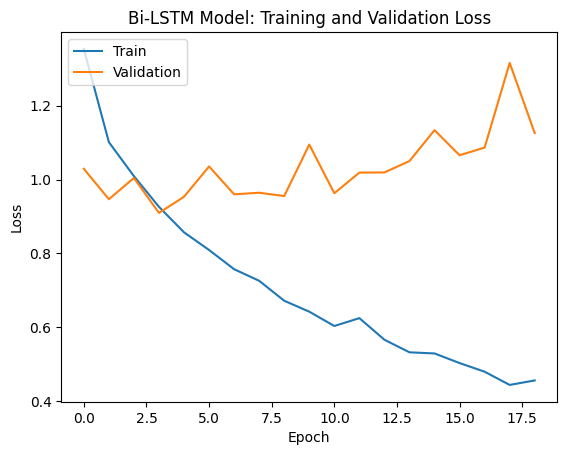

In [110]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Bi-LSTM Model: Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Model Performances

In [111]:
# Gabungkan data numerik dengan data teks untuk prediksi
y_pred_prob = model3.predict([testing_padded, X_test_numerical])
y_pred_classes = np.argmax(y_pred_prob, axis=1)  # Get the predicted class

# Menampilkan classification report
print(classification_report(y_test, y_pred_classes))

# Menghitung metrik lainnya
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')  # Use weighted for multiclass
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

# Menghitung Quadratic Weighted Kappa
qwk = cohen_kappa_score(y_test, y_pred_classes, weights='quadratic')

# Menampilkan metrik secara terpisah
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'Quadratic Weighted Kappa: {qwk:.2f}')

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

           0       0.33      0.50      0.40       102
           1       0.27      0.27      0.27       182
           2       0.42      0.47      0.44       326
           3       0.48      0.42      0.45       632
           4       0.83      0.83      0.83      1554

    accuracy                           0.65      2796
   macro avg       0.47      0.50      0.48      2796
weighted avg       0.65      0.65      0.65      2796

Accuracy: 0.65
Precision: 0.65
Recall: 0.65
F1 Score: 0.65
Quadratic Weighted Kappa: 0.72


### Bi-GRU

In [112]:
input_text = Input(shape=(max_len,))
embedding = Embedding(vocab_size, embedding_dim, input_length=max_len)(input_text)
spatial_dropout = SpatialDropout1D(drop_value)(embedding)
bi_gru = Bidirectional(GRU(64, return_sequences=False))(spatial_dropout)
dropout = Dropout(drop_value)(bi_gru)

# Fitur numerik
input_numerical = Input(shape=(8,))  # 8 adalah jumlah fitur numerik

# Gabungkan output Bi-GRU dan fitur numerik
combined = Concatenate()([dropout, input_numerical])

# Lapisan Dense dan output
dense = Dense(64, activation='relu')(combined)
output = Dense(5, activation='softmax')(dense)

# Model
model4 = Model(inputs=[input_text, input_numerical], outputs=output)
model4.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.AdamW(), metrics=["accuracy"])
model4.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 123)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, 123, 32)        │         32,000 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout1d_4       │ (None, 123, 32)        │              0 │ embedding_4[0][0]      │
│ (SpatialDropout1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 128)            │         37,632 │ spatial_dropout1d_4[0… │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 128)            │              0 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_9             │ (None, 8)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 136)            │              0 │ dropout_4[0][0],       │
│ (Concatenate)             │                        │                │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 64)             │          8,768 │ concatenate_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 5)              │            325 │ dense_8[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 78,725 (307.52 KB)

 Trainable params: 78,725 (307.52 KB)

 Non-trainable params: 0 (0.00 B)

#### Train the Model

In [113]:
history4 = model4.fit([training_padded, X_train_numerical], y_train, epochs=30,
                    validation_data=([testing_padded, X_test_numerical], y_test),
                    class_weight=class_weight_dict, verbose=1, callbacks=[early_stop])


Epoch 1/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.4411 - loss: 1.4733 - val_accuracy: 0.5433 - val_loss: 1.0424
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5786 - loss: 1.1596 - val_accuracy: 0.4968 - val_loss: 1.1223
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.5968 - loss: 1.0653 - val_accuracy: 0.5944 - val_loss: 0.9272
Epoch 4/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6372 - loss: 0.9908 - val_accuracy: 0.6209 - val_loss: 0.9017
Epoch 5/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6597 - loss: 0.9193 - val_accuracy: 0.6255 - val_loss: 0.9166
Epoch 6/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.6852 - loss: 0.8536 - val_accuracy: 0.5651 - val_loss: 1.0211
Epoch 7/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6938 - loss: 0.7965 - val_accuracy: 0.4914 - val_loss: 1.1844
Epoch 8/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6733 - loss: 0.7566 - val_accu

#### Trained Model Loss Visualization

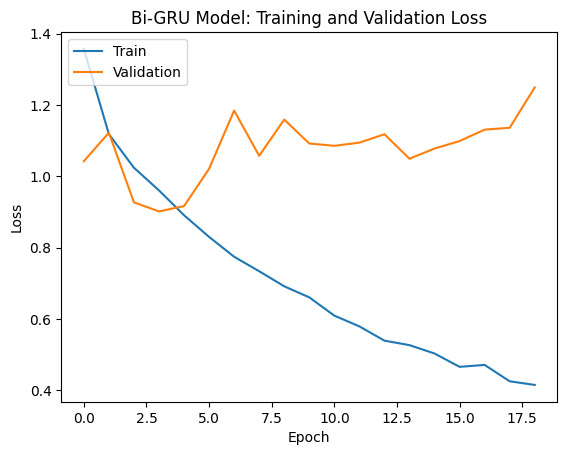

In [114]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Bi-GRU Model: Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Model Performances

In [115]:
# Gabungkan data numerik dengan data teks untuk prediksi
y_pred_prob = model4.predict([testing_padded, X_test_numerical])
y_pred_classes = np.argmax(y_pred_prob, axis=1)  # Get the predicted class

# Menampilkan classification report
print(classification_report(y_test, y_pred_classes))

# Menghitung metrik lainnya
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')  # Use weighted for multiclass
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

# Menghitung Quadratic Weighted Kappa
qwk = cohen_kappa_score(y_test, y_pred_classes, weights='quadratic')

# Menampilkan metrik secara terpisah
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'Quadratic Weighted Kappa: {qwk:.2f}')

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

           0       0.33      0.46      0.39       102
           1       0.30      0.31      0.30       182
           2       0.36      0.46      0.40       326
           3       0.40      0.59      0.48       632
           4       0.91      0.65      0.76      1554

    accuracy                           0.59      2796
   macro avg       0.46      0.50      0.47      2796
weighted avg       0.67      0.59      0.61      2796

Accuracy: 0.59
Precision: 0.67
Recall: 0.59
F1 Score: 0.61
Quadratic Weighted Kappa: 0.73


### Transformer With Multi-head Attention

In [116]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [117]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [119]:
embed_dim = 64  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 128  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(max_len,))
embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(5, activation="softmax")(x)

model5 = keras.Model(inputs=inputs, outputs=outputs)

In [121]:
# Input untuk teks dan fitur numerik
input_text = layers.Input(shape=(max_len,))
input_numerical = layers.Input(shape=(8,))  # 8 adalah jumlah fitur numerik

# Embedding layer
embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)
x = embedding_layer(input_text)

# Transformer block
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)

# Global pooling dan dropout
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)

# Gabungkan dengan fitur numerik
x = layers.Concatenate()([x, input_numerical])

# Dense layers
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(5, activation="softmax")(x)

# Model
model5 = keras.Model(inputs=[input_text, input_numerical], outputs=outputs)

#### Train the Model

In [123]:
model5.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.AdamW(), metrics=["accuracy"])

# Melakukan pelatihan model
history5 = model5.fit(
    [training_padded, X_train_numerical], y_train,
    batch_size=32, epochs=30,
    validation_data=([testing_padded, X_test_numerical], y_test),
    class_weight=class_weight_dict,
    verbose=1, callbacks=[early_stop]
)

Epoch 1/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 49s 34ms/step - accuracy: 0.1954 - loss: 1.6553 - val_accuracy: 0.5658 - val_loss: 1.2061
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5101 - loss: 1.3571 - val_accuracy: 0.5866 - val_loss: 0.9601
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6054 - loss: 1.0916 - val_accuracy: 0.6280 - val_loss: 0.8872
Epoch 4/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6523 - loss: 0.9237 - val_accuracy: 0.6012 - val_loss: 0.8974
Epoch 5/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6685 - loss: 0.8314 - val_accuracy: 0.5601 - val_loss: 0.9861
Epoch 6/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6782 - loss: 0.7653 - val_accuracy: 0.6202 - val_loss: 0.9656
Epoch 7/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6960 - loss: 0.7210 - val_accuracy: 0.6059 - val_loss: 0.9892
Epoch 8/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7156 - loss: 0.6708 - val_accuracy: 

#### Trained Model Loss Visualization

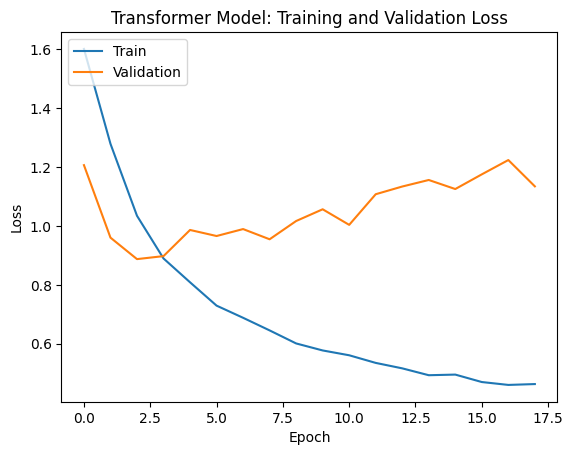

In [124]:
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Transformer Model: Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Model Performances

In [125]:
# Melakukan prediksi
y_pred_prob = model5.predict([testing_padded, X_test_numerical])
y_pred_classes = np.argmax(y_pred_prob, axis=1)  # Mendapatkan kelas yang diprediksi

# Menampilkan classification report
print(classification_report(y_test, y_pred_classes))

# Menghitung metrik lainnya
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

# Menghitung Quadratic Weighted Kappa
qwk = cohen_kappa_score(y_test, y_pred_classes, weights='quadratic')

# Menampilkan metrik secara terpisah
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'Quadratic Weighted Kappa: {qwk:.2f}')

88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
              precision    recall  f1-score   support

           0       0.49      0.36      0.42       102
           1       0.33      0.43      0.37       182
           2       0.40      0.50      0.44       326
           3       0.47      0.52      0.49       632
           4       0.87      0.77      0.81      1554

    accuracy                           0.64      2796
   macro avg       0.51      0.52      0.51      2796
weighted avg       0.67      0.64      0.66      2796

Accuracy: 0.64
Precision: 0.67
Recall: 0.64
F1 Score: 0.66
Quadratic Weighted Kappa: 0.72


## Final Training With Transformer Architecture

In [126]:
# Tokenization dan Padding untuk data pelatihan
tokenizer = Tokenizer(num_words=vocab_size, char_level=False, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['Text'])

X_sequences = tokenizer.texts_to_sequences(train_df['Text'])
X_padded = pad_sequences(X_sequences, maxlen=max_len, padding='pre', truncating='post')

# Fitur numerik
X_numerical = train_df[['Title_Negative', 'Title_Neutral', 'Title_Positive', 'Title_Compound',
                        'Review_Negative', 'Review_Neutral', 'Review_Positive', 'Review_Compound']].values

# Label
y = train_df['Rating'] - 1  # Pastikan label dimulai dari 0
y = y.astype(int)
y = np.array(y)

In [127]:
embed_dim = 64  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 128  # Hidden layer size in feed forward network inside transformer

# Input untuk teks dan fitur numerik
input_text = layers.Input(shape=(max_len,))
input_numerical = layers.Input(shape=(8,))  # 8 adalah jumlah fitur numerik

# Embedding layer
embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)
x = embedding_layer(input_text)

# Transformer block
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)

# Global pooling dan dropout
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)

# Gabungkan dengan fitur numerik
x = layers.Concatenate()([x, input_numerical])

# Dense layers
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(5, activation="softmax")(x)

# Model
model5 = keras.Model(inputs=[input_text, input_numerical], outputs=outputs)

In [128]:
model5.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.AdamW(), metrics=["accuracy"])

# Melakukan pelatihan model
history5 = model5.fit(
    [X_padded, X_numerical], y,
    batch_size=32, epochs=30,
    class_weight=class_weight_dict,
    verbose=1, callbacks=[early_stop]
)

Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.3747 - loss: 1.5686
Epoch 2/30
 34/350 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6015 - loss: 1.0705

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6026 - loss: 1.1062
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6642 - loss: 0.9223
Epoch 4/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6857 - loss: 0.8443
Epoch 5/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7041 - loss: 0.7849
Epoch 6/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7169 - loss: 0.7267
Epoch 7/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7213 - loss: 0.6846
Epoch 8/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7234 - loss: 0.6540
Epoch 9/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7288 - loss: 0.6592
Epoch 10/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7340 - loss: 0.6113
Epoch 11/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7434 - loss: 0.5823
Epoch 12/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7511 - loss: 0.5661
Epoch 13/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accur

In [ ]:
# # Model Bi-GRU dengan fitur numerik
# input_text = layers.Input(shape=(max_len,))
# input_numerical = layers.Input(shape=(8,))  # 8 adalah jumlah fitur numerik

# # Embedding dan Bi-GRU
# embedding_layer = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len)
# x = embedding_layer(input_text)
# x = layers.SpatialDropout1D(drop_value)(x)
# x = layers.Bidirectional(layers.GRU(64, return_sequences=False))(x)
# x = layers.Dropout(drop_value)(x)

# # Gabungkan dengan fitur numerik
# combined = layers.Concatenate()([x, input_numerical])

# # Dense layers
# x = layers.Dense(64, activation='relu')(combined)
# x = layers.Dropout(drop_value)(x)
# outputs = layers.Dense(5, activation='softmax')(x)

# # Model
# model4 = models.Model(inputs=[input_text, input_numerical], outputs=outputs)

# # Compile model
# model4.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.AdamW(), metrics=["accuracy"])

# # Melakukan pelatihan pada seluruh data dengan fitur numerik
# history4 = model4.fit(
#     [X_padded, X_numerical], y,
#     batch_size=32, epochs=30,
#     class_weight=class_weight_dict,
#     verbose=1, callbacks=[early_stop]
# )

In [129]:
# Tokenization dan Padding untuk data uji
X_test_sequences = tokenizer.texts_to_sequences(test_df['Text'])
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len, padding='pre', truncating='post')

# Fitur numerik untuk data uji
X_test_numerical = test_df[['Title_Negative', 'Title_Neutral', 'Title_Positive', 'Title_Compound',
                            'Review_Negative', 'Review_Neutral', 'Review_Positive', 'Review_Compound']].values

# Melakukan prediksi dengan model4 (Bi-GRU) pada data uji
predictions = model5.predict([X_test_padded, X_test_numerical], batch_size=32)

# Mendapatkan kelas yang diprediksi
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes += 1  # Menambahkan 1 untuk menyesuaikan dengan label yang dimulai dari 1
predicted_classes = predicted_classes.astype(int)

184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


In [130]:
# Membuat DataFrame untuk pengiriman
submission_df = pd.DataFrame({
    'ID': pd.Series([i for i in range(0, 5872)]),
    'Rating': predicted_classes
})

# Menampilkan DataFrame submission
submission_df

,ID,Rating
0,0,5
1,1,5
2,2,5
3,3,5
4,4,1
...,...,...
5867,5867,5
5868,5868,5
5869,5869,4
5870,5870,3


In [131]:
submission_df.to_csv('submission_final.csv', index=False)